In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [ ]:
pip install mujoco

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class IndependentNoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017, noise_dist='gaussian', noise_params=None):
        """
        noise_dist: 'gaussian', 'beta', or 'gamma'
        noise_params: dictionary for additional parameters.
          For 'beta': keys 'alpha' and 'beta' (defaults: 2.0, 2.0)
          For 'gamma': keys 'shape' and 'scale' (defaults: 2.0, 1.0)
        """
        super(IndependentNoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.noise_dist = noise_dist
        self.noise_params = noise_params or {}

        # Learnable parameters for weights and biases
        self.mu_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.sigma_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("epsilon_weight", torch.empty(out_features, in_features))

        self.mu_bias = nn.Parameter(torch.empty(out_features))
        self.sigma_bias = nn.Parameter(torch.empty(out_features))
        self.register_buffer("epsilon_bias", torch.empty(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        bound = 1 / np.sqrt(self.in_features)
        self.mu_weight.data.uniform_(-bound, bound)
        self.sigma_weight.data.fill_(self.sigma_init / np.sqrt(self.in_features))
        self.mu_bias.data.uniform_(-bound, bound)
        self.sigma_bias.data.fill_(self.sigma_init / np.sqrt(self.out_features))

    def reset_noise(self):
        if self.noise_dist == 'gaussian':
            self.epsilon_weight.normal_()  # Independent Gaussian N(0,1)
            self.epsilon_bias.normal_()
        elif self.noise_dist == 'beta':
            # Get Beta distribution parameters; default (2,2)
            alpha_val = self.noise_params.get("alpha", 2.0)
            beta_val  = self.noise_params.get("beta", 2.0)
            beta_dist = torch.distributions.Beta(torch.tensor([alpha_val]), torch.tensor([beta_val]))
            eps_w = beta_dist.sample((self.out_features, self.in_features)).squeeze()
            self.epsilon_weight.copy_((eps_w - 0.5) * 2.0)
            eps_b = beta_dist.sample((self.out_features,)).squeeze()
            self.epsilon_bias.copy_((eps_b - 0.5) * 2.0)
        elif self.noise_dist == 'gamma':
            # Get Gamma distribution parameters; default shape=2.0, scale=1.0
            shape_val = self.noise_params.get("shape", 2.0)
            scale_val = self.noise_params.get("scale", 1.0)
            gamma_dist = torch.distributions.Gamma(torch.tensor([shape_val]), torch.tensor([scale_val]))
            noise_w = gamma_dist.sample((self.out_features, self.in_features)).squeeze()
            noise_b = gamma_dist.sample((self.out_features,)).squeeze()
            mean_val = shape_val * scale_val
            std_val  = np.sqrt(shape_val) * scale_val
            self.epsilon_weight.copy_((noise_w - mean_val) / std_val)
            self.epsilon_bias.copy_((noise_b - mean_val) / std_val)
        else:
            raise ValueError("Unknown noise distribution: {}".format(self.noise_dist))

    def forward(self, x):
        if self.training:
            weight = self.mu_weight + self.sigma_weight * self.epsilon_weight
            bias = self.mu_bias + self.sigma_bias * self.epsilon_bias
        else:
            weight = self.mu_weight
            bias = self.mu_bias
        return F.linear(x, weight, bias)

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian', noise_params=None):
        super(PolicyNetwork, self).__init__()
        self.l1 = IndependentNoisyLinear(state_dim, 400, noise_dist=noise_dist, noise_params=noise_params)
        self.l2 = IndependentNoisyLinear(400, 300, noise_dist=noise_dist, noise_params=noise_params)
        self.l3 = IndependentNoisyLinear(300, action_dim, noise_dist=noise_dist, noise_params=noise_params)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.max_action * torch.tanh(self.l3(x))

    def reset_noise(self):
        self.l1.reset_noise()
        self.l2.reset_noise()
        self.l3.reset_noise()

class ValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ValueNetwork, self).__init__()
        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        return self.l3(x1)


In [ ]:
class TD3:
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian', noise_params=None, gamma=0.99):
        self.actor = PolicyNetwork(state_dim, action_dim, max_action, noise_dist=noise_dist, noise_params=noise_params).to(device)
        self.actor_target = PolicyNetwork(state_dim, action_dim, max_action, noise_dist=noise_dist, noise_params=noise_params).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = ValueNetwork(state_dim, action_dim).to(device)
        self.critic_target = ValueNetwork(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.gamma = gamma

    def train(self, replay_buffer, batch_size=64):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        state      = torch.FloatTensor(state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done       = torch.FloatTensor(done).to(device)

        next_action = self.actor_target(next_state)
        target_Q1, target_Q2 = self.critic_target(next_state, next_action)
        target_Q = torch.min(target_Q1, target_Q2)
        target_Q = reward + (1 - done) * self.gamma * target_Q.detach()

        current_Q1, current_Q2 = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        tau = 0.005
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        self.actor.reset_noise()

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


In [ ]:
class PrioritizedMemory:
    def __init__(self, max_size=1e6):
        self.max_size = int(max_size)
        self.storage = []

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage.pop(0)
        self.storage.append(data)

    def sample(self, batch_size):
        batch = random.sample(self.storage, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward.reshape(-1,1), next_state, done.reshape(-1,1)

In [ ]:
class ActorAttention(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian', noise_params=None):
        super(ActorAttention, self).__init__()
        # Each state feature becomes a token
        self.embedding = nn.Linear(1, 64)  # Map each scalar to a 64-dim token
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=True)
        # After attention, flatten tokens and pass through noisy linear layers
        self.fc1 = IndependentNoisyLinear(state_dim * 64, 400, noise_dist=noise_dist, noise_params=noise_params)
        self.fc2 = IndependentNoisyLinear(400, 300, noise_dist=noise_dist, noise_params=noise_params)
        self.fc3 = IndependentNoisyLinear(300, action_dim, noise_dist=noise_dist, noise_params=noise_params)
        self.max_action = max_action

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(-1)  # (batch, state_dim, 1)
        x = self.embedding(x)  # (batch, state_dim, 64)
        attn_output, _ = self.attention(x, x, x)  # (batch, state_dim, 64)
        x = attn_output.view(batch_size, -1)  # Flatten to (batch, state_dim*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

    def reset_noise(self):
        self.fc1.reset_noise()
        self.fc2.reset_noise()
        self.fc3.reset_noise()

# TD3 Agent variant using the attention-based actor
class TD3_Attn(TD3):
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian', noise_params=None, gamma=0.99):
        self.actor = ActorAttention(state_dim, action_dim, max_action, noise_dist=noise_dist, noise_params=noise_params).to(device)
        self.actor_target = ActorAttention(state_dim, action_dim, max_action, noise_dist=noise_dist, noise_params=noise_params).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = ValueNetwork(state_dim, action_dim).to(device)
        self.critic_target = ValueNetwork(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.gamma = gamma

In [ ]:
def fgsm_attack(state, agent, epsilon):
    """
    Generates an adversarially perturbed state using FGSM.
    Here we compute the gradient of the critic's Q1 value with respect to the input state
    and perturb the state in the direction that increases the loss.
    """
    s = torch.FloatTensor(state.reshape(1, -1)).to(device)
    s.requires_grad = True

    # Forward pass: get action from actor and Q-value from critic
    action = agent.actor(s)
    q_val = agent.critic.Q1(s, action)

    # Loss defined as negative Q-value (to lower performance)
    loss = -q_val
    agent.actor.zero_grad()
    agent.critic.zero_grad()
    loss.backward()

    grad_sign = s.grad.data.sign()
    s_adv = s + epsilon * grad_sign
    return s_adv.detach().cpu().numpy().flatten()


In [ ]:
def evaluate_agent(agent, env, num_episodes=1000, adv_epsilon=0.0):
    """
    Evaluates the agent for a given number of episodes.
    If adv_epsilon > 0, applies FGSM-based perturbations to the state.
    Returns the average episode reward.
    """
    total_reward = 0
    for ep in range(num_episodes):
        state, _ = env.reset()
        ep_reward = 0
        done = False
        while not done:
            if adv_epsilon > 0:
                state_adv = fgsm_attack(state, agent, adv_epsilon)
                action = agent.select_action(state_adv)
            else:
                action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            state = next_state
        total_reward += ep_reward
    return total_reward / num_episodes

Epsilon: 0.000 | Baseline Reward: 31.77 | Attention Reward: 24.08
Epsilon: 0.001 | Baseline Reward: 31.75 | Attention Reward: 24.07
Epsilon: 0.005 | Baseline Reward: 31.70 | Attention Reward: 24.07
Epsilon: 0.010 | Baseline Reward: 31.62 | Attention Reward: 24.07
Epsilon: 0.020 | Baseline Reward: 31.51 | Attention Reward: 24.07


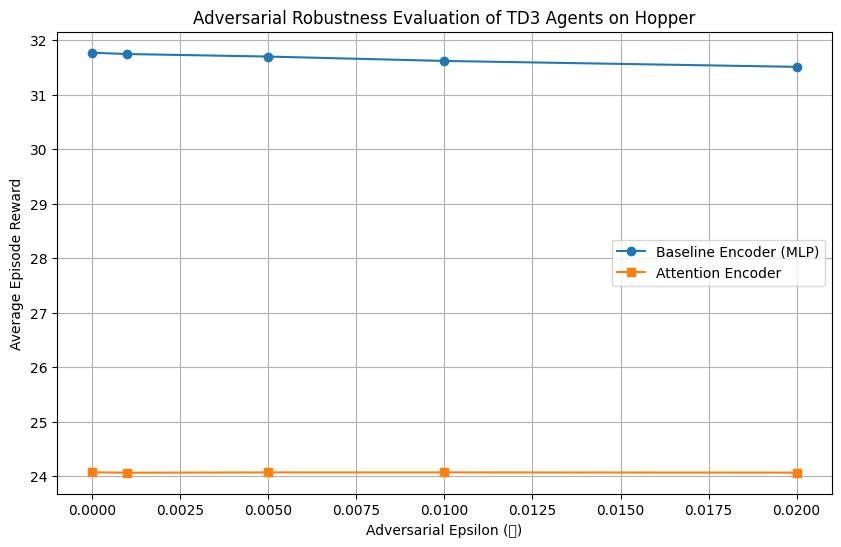

In [ ]:
adv_epsilons = [0.0, 0.001, 0.005, 0.01, 0.02]

# Create the Hopper environment
env = gym.make("Hopper-v4")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# Instantiate baseline TD3 agent (MLP-based actor using NoisyNet layers)
baseline_agent = TD3(state_dim, action_dim, max_action, noise_dist='gaussian')
# Instantiate alternative TD3 agent with attention-based actor
attention_agent = TD3_Attn(state_dim, action_dim, max_action, noise_dist='gaussian')

# Evaluate both agents under various adversarial strengths
baseline_rewards = []
attention_rewards = []

num_eval_episodes = 5000

for eps in adv_epsilons:
    avg_reward_baseline = evaluate_agent(baseline_agent, env, num_episodes=num_eval_episodes, adv_epsilon=eps)
    baseline_rewards.append(avg_reward_baseline)
    avg_reward_attention = evaluate_agent(attention_agent, env, num_episodes=num_eval_episodes, adv_epsilon=eps)
    attention_rewards.append(avg_reward_attention)
    print(f"Epsilon: {eps:.3f} | Baseline Reward: {avg_reward_baseline:.2f} | Attention Reward: {avg_reward_attention:.2f}")

env.close()

# Plot the performance curves
plt.figure(figsize=(10,6))
plt.plot(adv_epsilons, baseline_rewards, label="Baseline Encoder (MLP)", marker='o')
plt.plot(adv_epsilons, attention_rewards, label="Attention Encoder", marker='s')
plt.xlabel("Adversarial Epsilon (𝜖)")
plt.ylabel("Average Episode Reward")
plt.title("Adversarial Robustness Evaluation of TD3 Agents on Hopper")
plt.legend()
plt.grid(True)
plt.show()
